In [1]:
from gibbs import *
from data_simu import *
from mcmc_plot import *
from geweke_full import *
from data_pertub import *

## 1.Simulate Data

I simulate the data according to 

$$X= WZ + \sigma^2 I_n$$
where 

 1. $\sigma^2$ is a scalar for the noise parameter
 2. $(Z_i)_{qx1} \sim N(0, I_q)$ is the principle component vector for i-th observation
 3. $(\alpha_j)_{}$ is the precision vector parameter for $W$ matrix
 4. $(W_j)_{dx1} \sim N(0, v_jI_d)$ is the j-th column of $W$ projection matrix

In the following simualation, I chose d = 5, q_star = 1, meaning there is only one important component driving 5 dimensional data $X$

In [ ]:
# data dimension
d = 5
# true component dimension
q_star = d-1
# sample size
n_sample = 1000
# true sigma2
sigma2_star = 1
# true component variance parameter
a_star_list = 1 / np.linspace(1,10,q_star)

In [ ]:
X = generate_data(d, q_star, n_sample, sigma2_star, a_star_list)

In [ ]:
plt.figure(figsize=(10,6))
pd.plotting.scatter_matrix(pd.DataFrame(X).T)
plt.xlabel('Component i')
plt.ylabel('Component j')

In [ ]:
def component_posterior(comp_index, W_list, Z_list):
    """
        Function to plot the component residuals
        param: comp_index. list of compoents indexs used to restore the original data X
    """
    x_list=[]
    for sub_chains in range(n_chains):

        for iters in range(len(W_list[sub_chains])):
            y_hat = np.dot(W_list[sub_chains][iters][:,comp_index].reshape([d,len(comp_index)]), Z_list[sub_chains][iters][comp_index,:].reshape([len(comp_index),n_sample]))

            x_list.append(X-y_hat)
    return x_list

## 2. Geweke Test

### 2.1 Geweke Test Setup

I simulate the data generating process iteration(500) tims and sample mcmc iteration(500) times to calcualte some statistics on the data X. The mcmc sample was thined by draw 1 sample evert 50 times

In [ ]:
q = d-1
a_vj = 0.5 * d * np.ones(q) + 1
epislon = 0.1

prior_param = dict({'beta_sigma2': 2,
                        'a_sigma2': 3,
                        'a_vj': a_vj,
                        'beta_vj': epislon * (a_vj - 1)
                        })

init_dict = dict({'Z0': np.random.normal(0, 1, [q, 1]),
                      "sigma20": np.random.gamma(3, 0.1),
                      "w0": np.random.normal(0, 1, [d, q]),
                      "v0": np.random.gamma(1, 2, d - 1)})   


iterations = 500
n_sample = 100
thin = 50

### 2.2 Geweke Result --- PP plot, density plot and autocorrelation plot

In [ ]:
forward_results, gibbs_results = geweke(iterations, d, q_star, prior_param, init_dict, n_sample, thining= thin)

plt.scatter(np.sort(np.array(forward_results)),
            np.sort(np.array(gibbs_results)))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


print(np.mean(np.array(forward_results)) / np.mean(gibbs_results))


sns.distplot(np.array(forward_results))
sns.distplot(np.array(gibbs_results))
plt.title('Denstiy Comparison')
plt.show()

a = gibbs_results
b = np.mean(gibbs_results)
plt.acorr(a - b, normed=True, usevlines=False, maxlags=10, label=u'thinned')
plt.title('Auto-Correlation-Plot')
plt.show()

## 3. Gibbs Sampling

In [2]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])


In [3]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])

count = CRP(n_sample, alpha)

d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epislon = float(data_config['epislon'])
beta_vj = epislon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


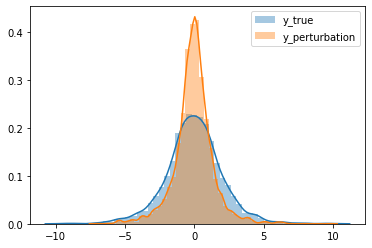

In [6]:
y_true = forward_sample(d, q_star, n_sample, prior_param_true, verbose=False)
y_perturbation = sample_perturbation(data_config, 0.05)

sns.distplot(y_true.ravel(), label='y_true')
sns.distplot(y_perturbation.ravel(), label='y_perturbation')
plt.legend()

In [7]:
X = y_perturbation

### 3.1 Prior Parameter Setup

In [8]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [9]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q_star)
epislon = float(mcmc_setup['epislon'])
beta_vj = epislon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': 0.5,
                    'a_sigma2': 3,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


Mean of true sigma2 0.29651396871775887


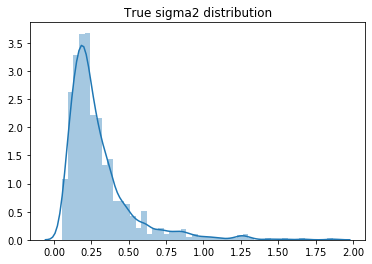

In [10]:
true_sigma2_sample = 1/np.random.gamma(prior_param_true['a_sigma2'], 1/ prior_param_true['beta_sigma2'], 1000 )
sns.distplot(true_sigma2_sample)
plt.title('True sigma2 distribution')
print('Mean of true sigma2 '+ str(np.mean(true_sigma2_sample)))

### 3.2 Inference Parameter Setup

In [11]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

### 3.3 Inference Sampling standard

In [12]:
mcmc_list = []
for sub_chains in range(n_chains):    
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, 1]),
                      "sigma20": np.random.gamma(prior_param_mcmc['a_sigma2'], 1/prior_param_mcmc['beta_sigma2']),
                      "w0": np.random.normal(0, 1, [d, q]),
                      "v0": np.random.gamma(1, 2, d - 1)})   
                      
    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi = 1)                      
    mcmc_list.append(inference.gibbs_result())

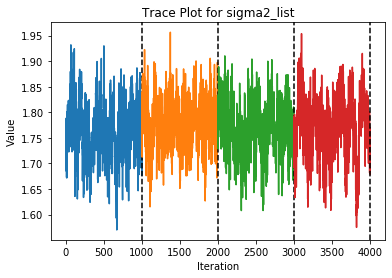

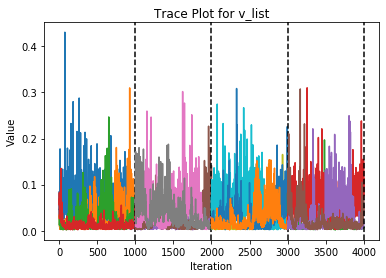

In [13]:
var_list = ['sigma2_list', 'v_list']
trace_plot(mcmc_list, var_list)

In [14]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

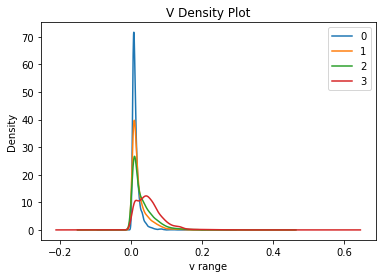

In [15]:
v_table = plot_v_density(v_list)

In [ ]:
np.mean(v_list, axis=1)

In [ ]:
print('Inference v' + str(v_table.mean().values))

print('True v'+ str(prior_param_true['beta_vj']/prior_param_true['a_vj']))

### 3.4 Inference Sampling Approxmiate

In [16]:
mcmc_list = []
for sub_chains in range(n_chains):    
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, 1]),
                      "sigma20": np.random.gamma(prior_param_mcmc['a_sigma2'], 1/prior_param_mcmc['beta_sigma2']),                      
#                      "sigma20": np.random.gamma(3, 0.1),
                      "w0": np.random.normal(0, 1, [d, q]),
                      "v0": np.random.gamma(1, 2, d - 1)})   
                      
    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi = xi)                      
    mcmc_list.append(inference.gibbs_result())

KeyboardInterrupt: 

In [ ]:
var_list = ['sigma2_list', 'v_list']
trace_plot(mcmc_list, var_list)

In [ ]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

In [ ]:
v_table = plot_v_density(v_list)
np.mean(v_list, axis=1)

In [ ]:
print('Inference v' + str(v_table.mean().values))

print('True v'+ str(prior_param_true['beta_vj']/prior_param_true['a_vj']))

In [ ]:
np.shape(sigma2_list)

In [ ]:
plt.acorr(sigma2_list[0], normed=True, usevlines=False, maxlags=10, label=u'thinned')
plt.show()